In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import warnings

warnings.filterwarnings("ignore")

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import imageio.v3 as imageio
from tqdm import tqdm
from scipy import sparse
from scipy.optimize import Bounds
import sklearn.gaussian_process as gpr
from pastillation.analysis.load_cv_result import load_best_keras_models


COLORS = []
colors = pplt.Cycle('538')
for color in colors:
    COLORS.append(color['color'])
colors = pplt.Cycle('Dark2')
for color in colors:
    COLORS.append(color['color'])

pplt.rc['figure.facecolor'] = 'white'

PLOT_DIR = "/Pastillation/figure/"
RESULT_PICKLE_DIR = "/Pastillation/result_pickle/"

WEIGHT_DIR = "/Pastillation/weight/"

### Edit T_sp  in the following block to set a different setpoint temperature.

In [ ]:
"""
Lx is the length in the x direction of the belt; it is assumed that each pellet row has 32 pellets with a gap of one pellet 
length around each for a total length of 2*(32)+1 = 65
Ly is the length in the y direction; it is assumed to be the length of belt required to accomodate 48 rows of water nozzles,
each with a spacing of 13 pellet lengths for a total length of (48+1)*13 = 637
Nx and Ny are set to the number of pellet lengths in Lx and Ly
dt is assumed to be equivalent to 0.5 seconds as the roller is assumed to place down pastilles at a rate of 1 row per second;
since there is a gap between the rows, each row is placed every other timestep, meaning two pass before a new is placed
T is the number of timesteps in the simulation
alpha is manually tuned to give a reasonable temperature profile
"""
Lx = 65
Nx = 65
nozzle_x_spacing = 1
Ly = 637
Ny = 637
nozzle_y_spacing = 13
space_parameters = [Lx, Nx, nozzle_x_spacing, Ly, Ny, nozzle_y_spacing]

dt = 1  
T = 801#1274#400#200#637
theta = 1
time_parameters = [T, dt, theta]

PID_BANK = np.array([[22.3199118, 47.0289928, 37.0235113, 45.78340451, 47.9383766, 100, 47.0290927],
                     [9.45040648, 15.328185, 0.1, 14.00165752, 16.1251270, 0.1, 0.1],
                     [0.0147050843, 0.0234222121, 0.0234222121, 0.31907698, 0.01, 0.0234222121, 0.0234222121]])
K_p = PID_BANK[0, 1]
t_I = PID_BANK[1, 1]
t_d = PID_BANK[2, 1]

T_sp = 14
u_bar = 2
control_parameters = [K_p, t_I, t_d, T_sp, u_bar]

alpha = 5.95*10**(-3)
T_0 = 72 # base or 0 temperature based on thermal camera

pellet_temps = np.loadtxt('../pastillation/data/pellet_temperatures_scaled.txt')


# BO tuning of PID
ub = np.array([25, 15, 3])
lb = np.array([5e-1, 5e-1, 5e-3])
dim = len(ub)
bounds = Bounds(np.zeros(dim), np.ones(dim))
exp_w = 2.6
kernel = gpr.kernels.Matern(length_scale = np.ones(dim),
                            length_scale_bounds = np.array([[1e-3, 1e3]]*dim),
                            nu = 2.5)
args = (space_parameters, [T_sp, u_bar], time_parameters, alpha, T_0, pellet_temps, True, True)


def gp_clogs(train, x_data = None, y_data = None, model = None, x = None, mu = None, sigma = None):
    # Train the model
    if train:
        mu = np.mean(x_data)
        sigma = np.std(x_data)
        x_norm = (x_data-mu)/sigma
        kernel = gpr.kernels.Matern(length_scale = 5,
                                    length_scale_bounds = (1, 10),
                                    nu = 1.5)
        model = gpr.GaussianProcessRegressor(kernel = kernel,
                                             alpha = 1e-6,
                                             n_restarts_optimizer = 10,
                                             normalize_y = True)
        model.fit(x_norm.reshape(-1, 1), y_data.reshape(-1, 1))
        return model, mu, sigma
    
    # generate predictions
    else:
        x_norm = (x-mu)/sigma
        return model.predict(x_norm.reshape(-1, 1))


def heat_sink(u, j, q_x, q_y, Nx, T_0):
    f_vec = np.zeros(Nx)
    rho_belt = 7850             # density of belt (carbon steel, kg/m3)
    V_belt = 0.0234**2*0.01*2   # volume of belt over nozzle assuming pastille diameter of 2.34 cm and belt thickness of 10 mm
    Cp_belt = 466               # heat capacity of belt (carbon steel, J/kg/K)
    m_water = 4*3.63/60/2/189   # flowrate of water (kg/timestep)
    T_water = 24.5              # initial temperature of cooling water (deg C)
    if j in q_y:
        f_vec[q_x] = -m_water*4148*(5/9*(u[j, q_x]+T_0-32)-T_water)/(rho_belt*V_belt*Cp_belt)
    return f_vec


def temperature_field_control(space_parameters, time_parameters, control_parameters, alpha, T_0, pellet_temps,
                              tune = False, close_figures = True, plot_field = False):
    
    models = load_best_keras_models(WEIGHT_DIR, RESULT_PICKLE_DIR)

    
    Lx = space_parameters[0]
    Nx = space_parameters[1]
    nozzle_x_spacing = space_parameters[2]
    Ly = space_parameters[3]
    Ny = space_parameters[4]
    nozzle_y_spacing = space_parameters[5]
    N = (Nx)*(Ny)
    m = lambda i, j: j*(Nx)+i
    
    T = time_parameters[0]
    dt = time_parameters[1]
    theta = time_parameters[2]
    
    K_p = control_parameters[0]
    t_I = control_parameters[1]
    t_d = control_parameters[2]
    T_sp = control_parameters[3]
    u_bar = int(control_parameters[4])
    
    x = np.linspace(0, Lx-1, Nx)
    y = np.linspace(0, Ly-1, Ny)
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    
    Nt = int(T/dt)+1
    t = np.linspace(0, T, Nt)

    Ix = range(0, Nx)
    Iy = range(0, Ny)
    It = range(0, Nt)
    
    Fx = alpha*dt/(dx**2)
    Fy = alpha*dt/(dy**2)
    
    error_history_temp = np.zeros(T)
    speed_profile = u_bar*np.ones(T, dtype = int)
    T_obs = np.ones(T)
    T_obs_real = np.ones(T)
    ROW = np.ones(T)
    
    
    # Mass flow tracking setup and initial conditions (t = 0)
    flow_in = np.zeros(Nx)
    flow_n = np.zeros((Ny, Nx))
    flow = np.zeros((Ny, Nx, Nt))

    flow[:, :, 0] = flow_n
    
    # Temperature tracking setup initial conditions (t = 0)
    u_n = np.zeros((Ny, Nx))
    u = np.zeros((Ny, Nx, Nt))
    
    u[:, :, 0] = u_n
    
    DsDt = np.zeros(Nt-1)
    outflow = []
    
    # setup of system of sparse linear system
    b = np.zeros(N)
    
    inferior = np.zeros(N-(Nx))     # sub-lower diagonal
    lower = np.zeros(N-1)           # lower diagonal
    main = np.zeros(N)              # main diagonal
    upper = np.zeros(N-1)           # upper diagonal
    superior = np.zeros(N-(Nx))     # super-upper diagonal
    
    ## top boundary
    j = 0
    main[m(0, j):m(Nx, j)] = 1
    
    for j in Iy[1:-1]:
        # left boundary
        i = 0
        main[m(i, j)] = 1
        # right boundary
        i = Nx-1
        main[m(i, j)] = 1
        # interior points
        superior[m(1, j):m(Nx-1, j)] = -theta*Fy
        upper[m(1, j):m(Nx-1, j)] = -theta*Fx
        
        main[m(1, j):m(Nx-1, j)] = 1+2*theta*(Fx+Fy)
        
        lower[m(1, j)-1:m(Nx-1, j)-1] = -theta*Fx
        inferior[m(1, j)-(Nx):m(Nx-1, j)-(Nx)] = -theta*Fy
    
    ## bottom boundary
    j = Ny-1
    main[m(0, j):m(Nx, j)] = 1
    
    
    ## build sparse coefficient matrix A
    A = sparse.diags(diagonals = [main, lower, upper, inferior, superior],
                     offsets = [0, -1, 1, -(Nx), Nx],
                     shape = (N, N),
                     format = 'csr')
    
    
    # Solve system of equations Ac = b
    for n in tqdm(It[0:-1], total=len(It[0:-1])):
        ## set sinks (water nozzles) as forcing function that cover a 3x3 square centered on the nozzle
        if n == 0:
            ### x-coordinates of spaces in contact with water
            q_x = np.arange(0, Nx, nozzle_x_spacing, dtype = int)
            q_x = q_x[1:-1]
            #q_x = np.hstack([q_x-1, q_x, q_x+1])
            
            ### y-cordinates of spaces in contact with water
            q_y = np.arange(0, Ny, nozzle_y_spacing, dtype = int)
            q_y = q_y[1:]
            q_y = np.hstack([q_y-1, q_y, q_y+1])
        
    
        ## train model for predicting clogs
        if n == 0:
            loc = np.linspace(0, len(pellet_temps)-1, len(pellet_temps))
            model, mu, sigma = gp_clogs(True, x_data = loc, y_data = pellet_temps)
            position = []
        
        ## fill in temperature values along top boundary
        j = 0
        i = 0
        p = m(i, j)
        b[p] = 0
        k = -1
        
        position.append(0)
        
        for i in Ix[1:-1]:
            p = m(i, j)
            
            if (i+1)%2 == 0:
                k += 1
                source = gp_clogs(False, model = model, x = np.array([k]), mu = mu, sigma = sigma)
                seed = np.random.rand()
                source = max(0, np.sign(source-seed))
                flow_in[i] = source
                source = 140*source
                b[p] = source
            
            else:
                flow_in[i] = 0
                b[p] = 0
            
            flow_n[j, i] = flow_in[i]
            u_n[j, i] = b[p]
            
        i = Nx
        p = m(i, j)
        b[p] = 0
        
    
        ## calculate function values for internal y coordinate points
        for j in Iy[1:-1]:
            ### middle rows, left boundary
            i = 0
            p = m(i, j)
            b[p] = 0
    
            ### interior mesh points
            i_min = Ix[1]
            i_max = Ix[-1]
    
            if n == 0:
                b[m(i_min, j):m(i_max, j)] = u_n[j, i_min:i_max]+\
                                             (1-theta)*(Fx*(u_n[j, i_min-1:i_max-1]-\
                                                            2*u_n[j, i_min:i_max]+\
                                                            u_n[j, i_min+1:i_max+1])+\
                                                        Fy*(u_n[j-1, i_min:i_max]-\
                                                            2*u_n[j, i_min:i_max]+\
                                                            u_n[j+1, i_min:i_max]))+\
                                             theta*dt*heat_sink(u_n, j, q_x, q_y, Nx, T_0)[i_min:i_max]+\
                                             (1-theta)*dt*heat_sink(u_n, j, q_x, q_y, Nx, T_0)[i_min:i_max]
            else:
                b[m(i_min, j):m(i_max, j)] = u_n[j, i_min:i_max]+\
                                             (1-theta)*(Fx*(u_n[j, i_min-1:i_max-1]-\
                                                            2*u_n[j, i_min:i_max]+\
                                                            u_n[j, i_min+1:i_max+1])+\
                                                        Fy*(u_n[j-1, i_min:i_max]-\
                                                            2*u_n[j, i_min:i_max]+\
                                                            u_n[j+1, i_min:i_max]))+\
                                             theta*dt*heat_sink(u_n, j, q_x, q_y, Nx, T_0)[i_min:i_max]+\
                                             (1-theta)*dt*heat_sink(u_n, j, q_x, q_y, Nx, T_0)[i_min:i_max]
    
            ### middle rows right boundary
            i = Nx-1
            p = m(i, j)
            b[p]  = 0
    
    
        ### bottom boundary
        j = Ny-1
        b[m(0, j):m(Nx, j)] = u_n[Ny-1, :]
        
        ## solve system of linear equations
        c = sparse.linalg.spsolve(A, b)
        
        x_state_cnn = c.reshape(Ny, Nx)[..., np.newaxis]
        x_input_cnn = x_state_cnn[None, ...]
        xmin, xmax = 0.0, 140.0
        x_input_cnn = (x_input_cnn - xmin) / (xmax - xmin)
        
        T_pred = [models[q].predict(x_input_cnn, verbose=0) for q in range(len(models))]
        T_pred = np.array(T_pred).squeeze()[:, 0]
        T_mu = np.mean(T_pred, axis=0)
        T_obs[n] = T_mu
        
        ## calculate error between average pellet row temperature and desired setpoint and select new control action
        if n == 0:
            # T_obs[n] = np.mean(c.reshape(Ny, Nx)[n])
            T_obs_real[n] = np.mean(c.reshape(Ny, Nx)[n])
            error_temp = T_sp-T_obs[n]
            error_history_temp[n] = error_temp
            
            dsdt = K_p*(error_temp-error_history_temp[n-1]+dt/t_I*error_temp+
                        t_d*(error_temp-2*error_history_temp[n-1]+error_history_temp[n-2])/dt)
            dsdt = min(max(-1, dsdt), 1)
            speed = int(np.round(speed_profile[n-1]+dsdt, 0))
            speed = min(max(2, speed), 12)

            DsDt[n] = dsdt
            speed_profile[n] = speed
            row = position[0]
            
            DsDt[n] = dsdt
            speed_profile[n] = speed
            row = position[0]
                
        else:
            row = position[0]
            
            if row > Ny-1:
                position_dummy = []
                idx = np.where(np.array(position) > Ny-1)[0]
                past_end = np.array(position)[idx]-speed
                position_dummy = [position[i] for i, _ in enumerate(position) if i not in idx]
                position = position_dummy.copy()
                row = position[0]
                outflow.append(np.sum(flow[:, :, n][past_end]))
                 
                del position_dummy
            
            T_obs_real[n] = np.mean(c.reshape(Ny, Nx)[row])
            error_temp = T_sp-T_obs[n]
            error_history_temp[n] = error_temp
            
            dsdt = K_p*(error_temp-error_history_temp[n-1]+dt/t_I*error_temp+
                        t_d*(error_temp-2*error_history_temp[n-1]+error_history_temp[n-2])/dt)
            dsdt = min(max(-1, dsdt), 1)
            speed = int(np.round(speed_profile[n-1]+dsdt, 0))
            speed = min(max(2, speed), 12)

            DsDt[n] = dsdt
            speed_profile[n] = speed
            
        ## fill in flow and update flow_n
        flow[:, :, n+1] = flow_n.copy()
        flow_n[speed:, :] = flow_n[:-speed, :]
        flow_n[:speed] = 0
        
        ## fill in u and update u_n
        u[:, :, n+1] = c.reshape(Ny, Nx)
        u_n = u[:, :, n+1].copy()
        u_n[speed:, :] = u_n[:-speed, :]
        u_n[:speed] = 0
        
        # update position tracker
        position[:] = [p+speed for p in position]
        ROW[n] = position[0]
        
    if tune:
        first_row = np.where(ROW >= Ny-1)[0][0]
        error_history_temp = error_history_temp[first_row:]
    
    
    if plot_field:
        ## visualize temperature field
        gif_images_flow = []
        gif_images_temp = []
        ub = np.ceil(np.max(u))
        lb = np.floor(np.min(u))
        
        for i in range(Nt):
            plt.figure()
            plt.imshow(flow[:, :, i], cmap = 'binary', vmin = 0, vmax = 1)
            plt.xticks([])
            plt.yticks([])
            plt.savefig('flow_frame_'+str(i+1)+'.png', dpi = 300, edgecolor = 'white',
                        bbox_inches = 'tight', pad_inches = 0.1)
            plt.close()
            
            plt.figure()
            plt.imshow(u[:, :, i], cmap = 'jet', vmin = lb, vmax = ub)
            plt.xticks([])
            plt.yticks([])
            plt.savefig('temp_frame_'+str(i+1)+'.png', dpi = 300, edgecolor = 'white',
                        bbox_inches = 'tight', pad_inches = 0.1)
            plt.close()
            
            gif_images_flow.append(imageio.imread('flow_frame_'+str(i+1)+'.png'))
            os.remove('flow_frame_'+str(i+1)+'.png')
            
            gif_images_temp.append(imageio.imread('temp_frame_'+str(i+1)+'.png'))
            os.remove('temp_frame_'+str(i+1)+'.png')
        
        imageio.imwrite('flow_profile.gif', gif_images_flow, duration  = 50, loop = 0)
        imageio.imwrite('temperature_profile_'f'{T_sp}_degF.gif', gif_images_temp, duration  = 50, loop = 0)
        
    
    return flow, u, T_obs, T_obs_real, speed_profile, error_history_temp, outflow, DsDt

In [ ]:
result = temperature_field_control(space_parameters, time_parameters, control_parameters, alpha, T_0, pellet_temps,
                              tune = False, close_figures = False, plot_field = False)

with open(f"result_{T_sp}_duo.pickle", "wb") as handle:
    pickle.dump(result, handle)
    pickle.dump(space_parameters, handle)
    pickle.dump(time_parameters, handle)
    pickle.dump(control_parameters, handle)
    pickle.dump(alpha, handle)
    pickle.dump(T_0, handle)
    pickle.dump(pellet_temps, handle)

In [ ]:
with open(f"result_{T_sp}_duo.pickle", "rb") as handle:
    result = pickle.load(handle)
    space_parameters = pickle.load(handle)
    time_parameters = pickle.load(handle)
    control_parameters = pickle.load(handle)
    alpha = pickle.load(handle)
    T_0 = pickle.load(handle)
    pellet_temps = pickle.load(handle)


In [26]:
flow, u, T_obs, T_obs_real, speed_profile, error_history_temp, outflow, DsDt = result
t = np.arange(len(T_obs_real))

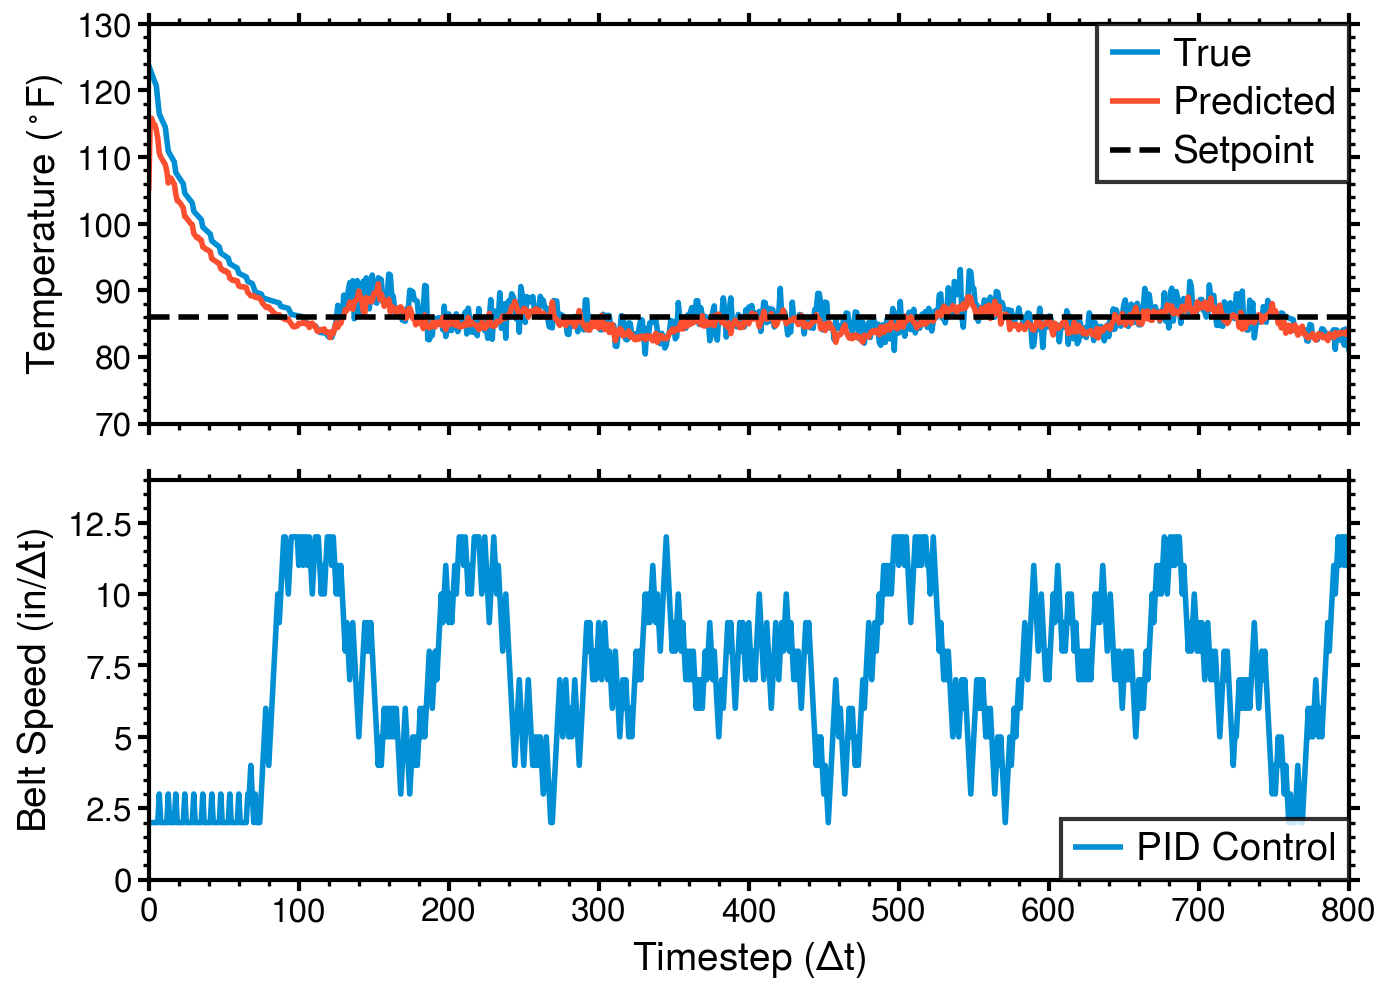

In [27]:
fig, ax = pplt.subplots(refwidth=6, refheight=2, nrows=2, sharey=False)

ax[0].plot(t, T_obs_real+T_0, lw = 2, label = 'True', c=COLORS[0])
ax[0].plot(t, T_obs+T_0, lw = 2, label = 'Predicted', c=COLORS[1])
ax[0].plot([0, t[-1]], [T_sp+T_0, T_sp+T_0], 'k--', lw = 2, label = 'Setpoint')

ax[1].plot(t, speed_profile, linewidth = 2, label = 'PID Control', c=COLORS[0])

for i in range(len(ax)):
    
    if i == 0:
        ylim = [70, 130]
        ylabel = r"Temperature ($^\circ$F)"
        loc = "upper right"
    else:
        ylim = [0, 14]
        ylabel = r"Belt Speed (in/$\Delta t$)"
        loc = "lower right"
        
    ax[i].tick_params(top=True, right=True, which="both")
    ax.minorticks_on()

    lgd = ax[i].legend(ncol=1, loc=loc, handleheight=1.5)
    lgd.get_frame().set_linewidth(1.5)


    for text in lgd.get_texts():
        text.set_fontsize(14)

    ax[i].grid()

    ax[i].format(
        xlim=[0, 800],
        ylim=ylim,
        xlabel=r"Timestep $(\Delta t)$",
        ylabel=ylabel,
        xlabelsize=14,
        ylabelsize=14,
        xticklabelsize=12,
        yticklabelsize=12,
        titlesize=16,
        titleweight="bold",
        tickdir="out",
        linewidth=1.5,
    )

fig.save(PLOT_DIR+f'pid_control_{T_sp}.png', dpi=600)